In [357]:
def rolling_avg(group, cols, new_cols):  ## takes small df for a single team and adds rolling avgs to df

    group = group.sort_values('date')
    rolling_stats = group[cols].rolling(3,closed='left').mean()   ## last 5 averaged
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group


def create_acronym(name, length=3):
    words = name.split()
    acronym = ''.join(word[:length].upper() for word in words)  
    return acronym[:length]  



In [358]:
import pandas as pd
import numpy as np


#############################################################################################################
############################################### PREPARING DATA ###############################################


data_23 = pd.read_csv('matches3.csv')
data_24 = pd.read_csv('matches4.csv')
full_data = pd.concat([data_23, data_24])


team_list_2324 = data_23['team'].unique()            ###   List of all the teams from 2023-24 season
team_list_2425 = data_24['team'].unique()            ###   List of all the teams from 2024-25 season
shared_teams = np.intersect1d(team_list_2324, team_list_2425)


team_name_mapping = {
    "Manchester Utd": "Manchester United",
    "Nott'ham Forest": "Nottingham Forest", 
    "Wolves": "Wolverhampton Wanderers", 
    "Tottenham": "Tottenham Hotspur", 
    "West Ham": "West Ham United", 
    "Brighton": "Brighton and Hove Albion", 
    "Newcastle Utd": "Newcastle United",  }

full_data['opponent'] = full_data['opponent'].replace(team_name_mapping)


filt_full_data = full_data[full_data['team'].isin(shared_teams) & full_data['opponent'].isin(shared_teams)] ## Removes any fixtures with promoted/relagated teams
filt_full_data = filt_full_data[['date','team','opponent','gf','ga','xg','xga','sot','pk','fk','venue','poss']]    ## Useful cols
filt_full_data['venue code'] = filt_full_data.loc[:,'venue'].astype('category').cat.codes  ## Makes Home/Away binary                  
filt_full_data = filt_full_data.reset_index()


cols = ['gf','ga','xg','xga','sot','poss']    ## cols we want to add rolling stats to
new_cols = [f'{x}_rolling' for x in cols]    ## adds rolling suffic to each stat in column


grouped_matches = filt_full_data.groupby('team')              ## all the matches grouped by team
rolling_df = grouped_matches.apply(lambda x : rolling_avg(x, cols, new_cols), include_groups=False).reset_index()    ## applying rolling averages to each group in the df. reset index keeps "team" as col header

### We also want the roling stats for the away team so need to create a new df and then merge together

opponent_stats = rolling_df.copy()
opponent_stats = opponent_stats.rename(columns={'opponent':'OP', 'team':'opponent', 'ga_rolling': 'opp_ga_rolling', 'gf_rolling':'opp_gf_rolling'})
opponent_stats = opponent_stats[['date', 'opponent', 'opp_ga_rolling', 'opp_gf_rolling']]


rolling_df = rolling_df.merge(opponent_stats, left_on=['opponent', 'date'], right_on=['opponent', 'date']) ## Merge with opponent stats

rolling_df['xg_strength'] = rolling_df['gf_rolling'] - rolling_df['opp_gf_rolling']
rolling_df['xg_ratio'] = (rolling_df['gf_rolling']) / (rolling_df['opp_gf_rolling'] + 0.01)



In [359]:
training_data = rolling_df[rolling_df['date'] < '2024-03-01']   ## Training data from before date
testing_data = rolling_df[rolling_df['date'] > '2024-03-01']    ## Testing data after date

prediction_metrics = ['venue code', 'gf_rolling', 'ga_rolling', 'sot_rolling', 'opp_gf_rolling', 'opp_ga_rolling']
#prediction_metrics = ['venue code', 'xg_strength', 'xg_ratio']
#prediction_metrics = ['gf_rolling']

<font size="12">LINEAR MODEL</font>

from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier


###########################################################################################################
######################################## Model for each team ##############################################
###########################################################################################################

linreg_dict = {}                          ## Empty dictionary for regression models 
for team in shared_teams:
    team_data = rolling_df[rolling_df['team'] == team]   ## 
    data = team_data
    data = data.copy()
    
    linreg = linear_model.LinearRegression()
    linreg_dict[team] = linreg.fit(data[prediction_metrics], data[['gf']])


lin_coef_df = pd.DataFrame(columns = ['Team'] + prediction_metrics)

for team_name, model in linreg_dict.items():
    dummy_row = []                                   ## Creates empty row
    dummy_row.append(team_name)                      ## Add the current team to row
    counter = 0                                      ## Resets counter to 0
    while  counter < len(prediction_metrics):        ## 
        dummy_row.append(model.coef_[0][counter])
        counter += 1
    lin_coef_df.loc[len(lin_coef_df)] = dummy_row

############################################################################################################
###########################################################################################################
###########################################################################################################
#lin_coef_df

In [367]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier


linreg_dict = {}                          ## Empty dictionary for regression models 


linreg = linear_model.LinearRegression()
linreg_fit = linreg.fit(training_data[prediction_metrics], training_data[['gf']])


lin_coef_df = pd.DataFrame(columns = ['Team'] + prediction_metrics)

for team_name, model in linreg_dict.items():
    dummy_row = []                                   ## Creates empty row
    dummy_row.append(team_name)                      ## Add the current team to row
    counter = 0                                      ## Resets counter to 0
    while  counter < len(prediction_metrics):        ## 
        dummy_row.append(model.coef_[0][counter])
        counter += 1
    lin_coef_df.loc[len(lin_coef_df)] = dummy_row#

In [425]:
lr_team_pred_dict = {}
for team in shared_teams:

    test_data = testing_data[testing_data['team'] == team]

    predicted_goals = linreg.predict(test_data[prediction_metrics]).flatten()
    lr_predicted_goals = predicted_goals.astype('int64')
    actual_goals = test_data['gf'].values
    lr_team_pred_dict[team] = [lr_predicted_goals, actual_goals]

lr_team_pred_df = pd.DataFrame(lr_team_pred_dict)

lr_diff_dict = {}
for col_name, col_values in lr_team_pred_df.items():
    diff_arr = np.abs(col_values[0] - col_values[1])
    lr_diff_dict[col_name] = np.sum(diff_arr)

lr_team_correct_number_dict = {}
for team in shared_teams:
    pred = lr_team_pred_dict[team][0]    ## all predicted goals for one team
    act = lr_team_pred_dict[team][1]     ## all actual goals for one team
    diff  = pred - act                   ## difference in predicted and actual
    correct = len(diff) - np.count_nonzero(diff)    ## number of correct scores
    lr_team_correct_number_dict[team] = correct     ## append number of correct scores to current team

lr_total_correct= sum(lr_team_correct_number_dict.values())   ## dont use numpy sum ---> gives array out


#lr_diff_dict
#lr_team_pred_df
lr_total_correct

157

<font size="12">FOREST MODEL</font>

In [362]:
from sklearn.metrics import accuracy_score

forest_reg = RandomForestClassifier(n_estimators=50, min_samples_split=20, random_state=1)
forest_reg_fit = forest_reg.fit(training_data[prediction_metrics], np.ravel(training_data[['gf']]))

forest_predictions = forest_reg_fit.predict(testing_data[prediction_metrics])

acc = accuracy_score(testing_data[['gf']], forest_predictions)
acc

0.302734375

In [427]:
fr_team_pred_dict = {}
for team in shared_teams:

    test_data = testing_data[testing_data['team'] == team]

    predicted_goals = forest_reg.predict(test_data[prediction_metrics]).flatten()
    fr_predicted_goals = predicted_goals.astype('int64')
    actual_goals = test_data['gf'].values
    fr_team_pred_dict[team] = [fr_predicted_goals, actual_goals]


fr_team_pred_df = pd.DataFrame(fr_team_pred_dict)

fr_diff_dict = {}
for col_name, col_values in fr_team_pred_df.items():
    diff_arr = np.abs(col_values[0] - col_values[1])
    fr_diff_dict[col_name] = np.sum(diff_arr)

fr_diff_dict

fr_team_correct_number_dict = {}
for team in shared_teams:
    pred = fr_team_pred_dict[team][0]    ## all predicted goals for one team
    act = fr_team_pred_dict[team][1]     ## all actual goals for one team
    diff  = pred - act                   ## difference in predicted and actual
    correct = len(diff) - np.count_nonzero(diff)    ## number of correct scores
    fr_team_correct_number_dict[team] = correct     ## append number of correct scores to current team

fr_total_correct= sum(fr_team_correct_number_dict.values())   ## dont use numpy sum ---> gives array out

fr_total_correct

155

<font size="12">POISSON MODEL</font>

In [428]:
import statsmodels.api as sm

team_pred_dict = {}


X = sm.add_constant(training_data[prediction_metrics])
Y = training_data['gf']
poisson_model = sm.Poisson(Y, X).fit()

Optimization terminated successfully.
         Current function value: 1.560588
         Iterations 5


In [429]:
ps_team_pred_dict = {}
for team in shared_teams:

    test_data = testing_data[testing_data['team'] == team]

    predicted_goals = poisson_model.predict(test_data[prediction_metrics])#.flatten()
    ps_predicted_goals = predicted_goals.astype('int64')
    actual_goals = test_data['gf'].values
    ps_team_pred_dict[team] = [ps_predicted_goals, actual_goals]


ps_team_pred_df = pd.DataFrame(ps_team_pred_dict)

ps_diff_dict = {}
for col_name, col_values in ps_team_pred_df.items():
    diff_arr = np.abs(col_values[0] - col_values[1])
    ps_diff_dict[col_name] = np.sum(diff_arr)


ps_team_correct_number_dict = {}
for team in shared_teams:
    pred = ps_team_pred_dict[team][0]    ## all predicted goals for one team
    act = ps_team_pred_dict[team][1]     ## all actual goals for one team
    diff  = pred - act                   ## difference in predicted and actual
    correct = len(diff) - np.count_nonzero(diff)    ## number of correct scores
    ps_team_correct_number_dict[team] = correct     ## append number of correct scores to current team

ps_total_correct= sum(ps_team_correct_number_dict.values())   ## dont use numpy sum ---> gives array out

ps_total_correct

146

<font size="12">PLOTTING</font>

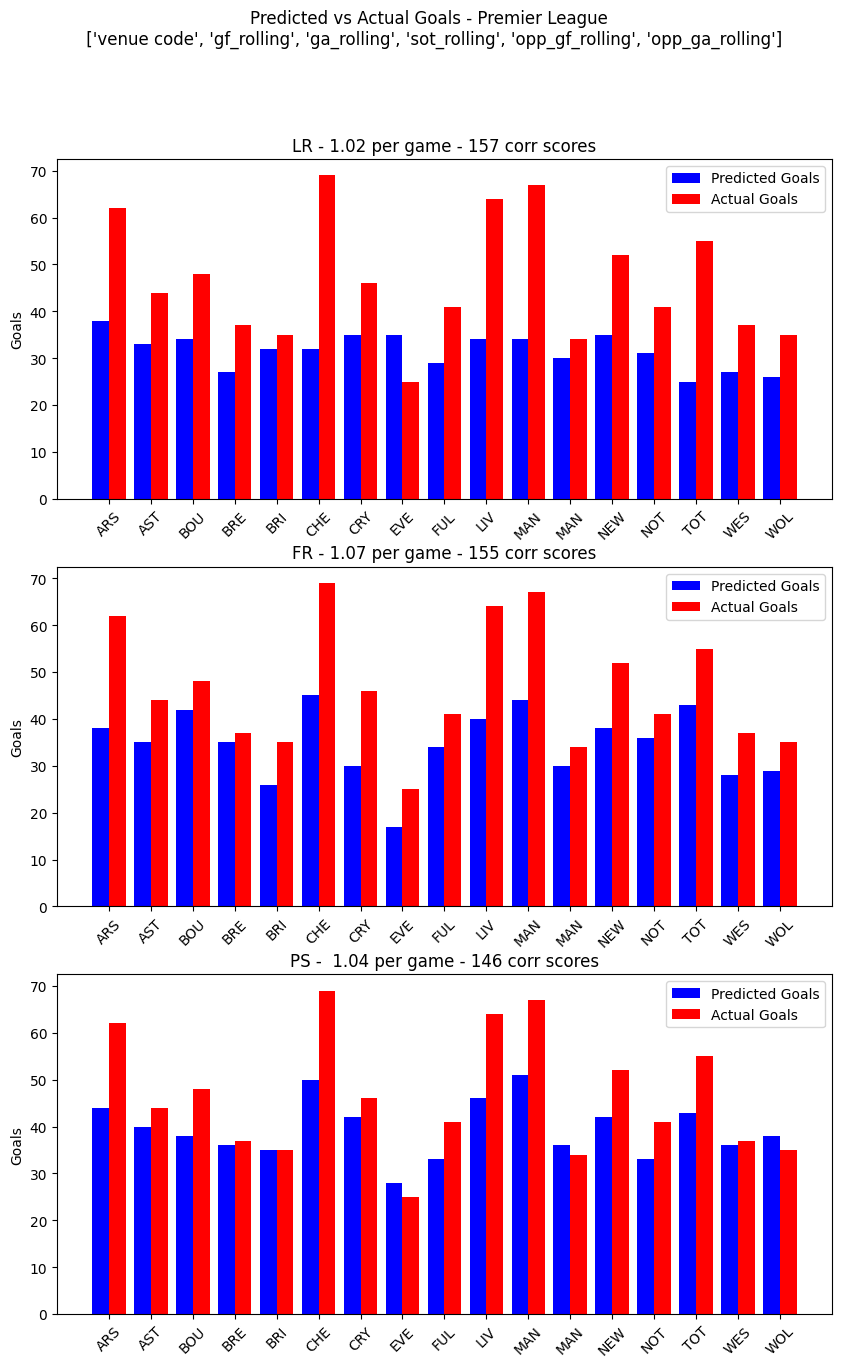

In [442]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


############################################ Finding total difference between predicted and actual goals ############################################        
LR_diff = 0
for name, item in lr_diff_dict.items(): 
    LR_diff += item   
    
FR_diff = 0
for name, item in fr_diff_dict.items(): 
    FR_diff += item  
    
PS_diff = 0
for name, item in ps_diff_dict.items(): 
    PS_diff += item  




full_lr_pred = []
full_fr_pred = []
full_ps_pred = []

actual_goals = []
team_list_reduced = []
for team in shared_teams:

    team_list_reduced.append(create_acronym(team))  ## runs acronym function for each team when appending to list
    
    full_lr_pred.append(lr_team_pred_dict[team][0].sum())   ## Creates array of total lr pred goals for each team
    full_fr_pred.append(fr_team_pred_dict[team][0].sum())   ## Creates array of total fr pred goals for each team
    full_ps_pred.append(ps_team_pred_dict[team][0].sum())   ## Creates array of total ps pred goals for each team

    actual_goals.append(lr_team_pred_dict[team][1].sum())   ## Creates array of total actual goals for each team

#print(len(team_list_reduced),len(full_lr_pred),len(actual_goals))

lr_data = {
    "Team": team_list_reduced,
    "Predicted Goals": full_lr_pred,
    "Actual Goals": actual_goals}
fr_data = {
    "Team": team_list_reduced,
    "Predicted Goals": full_fr_pred,
    "Actual Goals": actual_goals}
ps_data = {
    "Team": team_list_reduced,
    "Predicted Goals": full_ps_pred,
    "Actual Goals": actual_goals}

lr_df = pd.DataFrame(lr_data)
fr_df = pd.DataFrame(fr_data)
ps_df = pd.DataFrame(ps_data)

x = np.arange(len(lr_df))  ## Creates array of 0-16
width = 0.4  ## Width of barsr so gap between teams

## Plotting all the models
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

ax[0].bar(x - width/2, lr_df["Predicted Goals"], width, label="Predicted Goals", color="blue")
ax[0].bar(x + width/2, lr_df["Actual Goals"], width, label="Actual Goals", color="red")
ax[1].bar(x - width/2, fr_df["Predicted Goals"], width, label="Predicted Goals", color="blue")
ax[1].bar(x + width/2, fr_df["Actual Goals"], width, label="Actual Goals", color="red")
ax[2].bar(x - width/2, ps_df["Predicted Goals"], width, label="Predicted Goals", color="blue")
ax[2].bar(x + width/2, ps_df["Actual Goals"], width, label="Actual Goals", color="red")

## Labels
for i in range(0,len(ax)):
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(lr_df["Team"], rotation=45)
    ax[i].set_ylabel("Goals")
    ax[i].legend()


plt.suptitle(f'Predicted vs Actual Goals - Premier League \n {prediction_metrics}')
#plt.suptitle(f'{prediction_metrics}')
ax[0].set_title(f"LR - {round(LR_diff/len(testing_data), 2)} per game - {lr_total_correct} corr scores")
ax[1].set_title(f"FR - {round(FR_diff/len(testing_data), 2)} per game - {fr_total_correct} corr scores")
ax[2].set_title(f"PS -  {round(PS_diff/len(testing_data), 2)} per game - {ps_total_correct} corr scores")



#ax[i].legend()

## Show plot
#plt.savefig(f"Predicted vs Actual Goals - Premier League - {prediction_metrics} - {round(LR_diff, 2)}.png", dpi=300, bbox_inches='tight')
plt.show()